## QPE solutions for the popcount problem

In this notebook the possiblity of using quantum phase estimation to develop algorithms for the different popcount problem configurations is explored.

References:

* https://quantumcomputing.stackexchange.com/questions/16235/intuition-behind-the-use-of-inverse-fft-in-quantum-circuit-for-hamming-weight
* https://pennylane.ai/qml/demos/tutorial_qpe
* https://pennylane.ai/qml/demos/tutorial_qft


The following libraries were imported:

In [19]:
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer.primitives import Sampler
import copy
import pandas as pd

The spesific problem instance is defined:

In [20]:
# problem definition
n = 6

Function to prepare the initial states of the circuit. It takes a numpy array (input_boolean) containing booleans representing the binary string that should be prepared:

In [21]:
def prepare_input_state(input_boolean: np.ndarray, qreg: QuantumRegister, qc: QuantumCircuit): 
    for i, set_bit in enumerate(input_boolean):
        # For each bit in the bit string
        if set_bit:
            # If the bit is set (True), then apply the bit flip to the corresponding qubit
            qc.x(qreg[i])
            

The following functions create the different circuits that solve the popcount j=2 problem for $n > 0, n \in \mathbb{Z}$.

In [22]:
def create_QPE_popcount_circuit_rcx(qreg: QuantumRegister, qreg_result: QuantumRegister, creg: ClassicalRegister, qc: QuantumCircuit, n: int):
    # This function takes the quantum circuit as argument and applies the QFT solution using the CR_x(pi/2)
    # Note that the Hadamare gates are not used in this case
    for control_q in range(n):
        # Apply the crx gate with pi/2 as rotation angle (S gate) with each input qubit as control bit and the y_2 qubit as target.
        qc.crx(np.pi/2, qreg[control_q], qreg_result)

    for control_q in range(n-1):
        # Add the CNOT operators for each input qubit as controll except one which serves as target to get the y_1 value.
        qc.cx(qreg[control_q], qreg[n-1])

    # Add the inverse controlled operation once qwith y_1 as controll and y_2 as target. 
    qc.crx(-np.pi/2, qreg[n-1], qreg_result)
    # The y_2 qubit is measured
    qc.measure(qreg_result, creg)

def create_QPE_popcount_circuit_rcz(qreg: QuantumRegister, qreg_result: QuantumRegister, creg: ClassicalRegister, qc: QuantumCircuit, n: int):
    # This function takes the quantum circuit as argument and applies the QFT solution using the decomposition of CR_z(pi/2)
    for control_q in range(n):
        # Apply the crz gate with pi/2 as rotation angle (S gate) with each input qubit as control bit and the y_2 qubit as target.
        qc.rz(np.pi/4, qreg_result)
        qc.cx(qreg[control_q], qreg_result)
        qc.rz(-np.pi/4, qreg_result)
        qc.cx(qreg[control_q], qreg_result)
        

    for control_q in range(n-1):
        # Add the CNOT operators for each input qubit as controll except one which serves as target to get the y_1 value.
        qc.cx(qreg[control_q], qreg[n-1])

    # Add the inverse controlled operation once qwith y_1 as controll and y_2 as target. 
    qc.rz(-np.pi/4, qreg_result)
    qc.cx(qreg[n-1], qreg_result)
    qc.rz(np.pi/4, qreg_result)
    qc.cx(qreg[n-1], qreg_result)
    # The y_2 qubit is measured
    qc.measure(qreg_result, creg)

The next, cell is used to make a drawing of the circuit before adding input state preparation

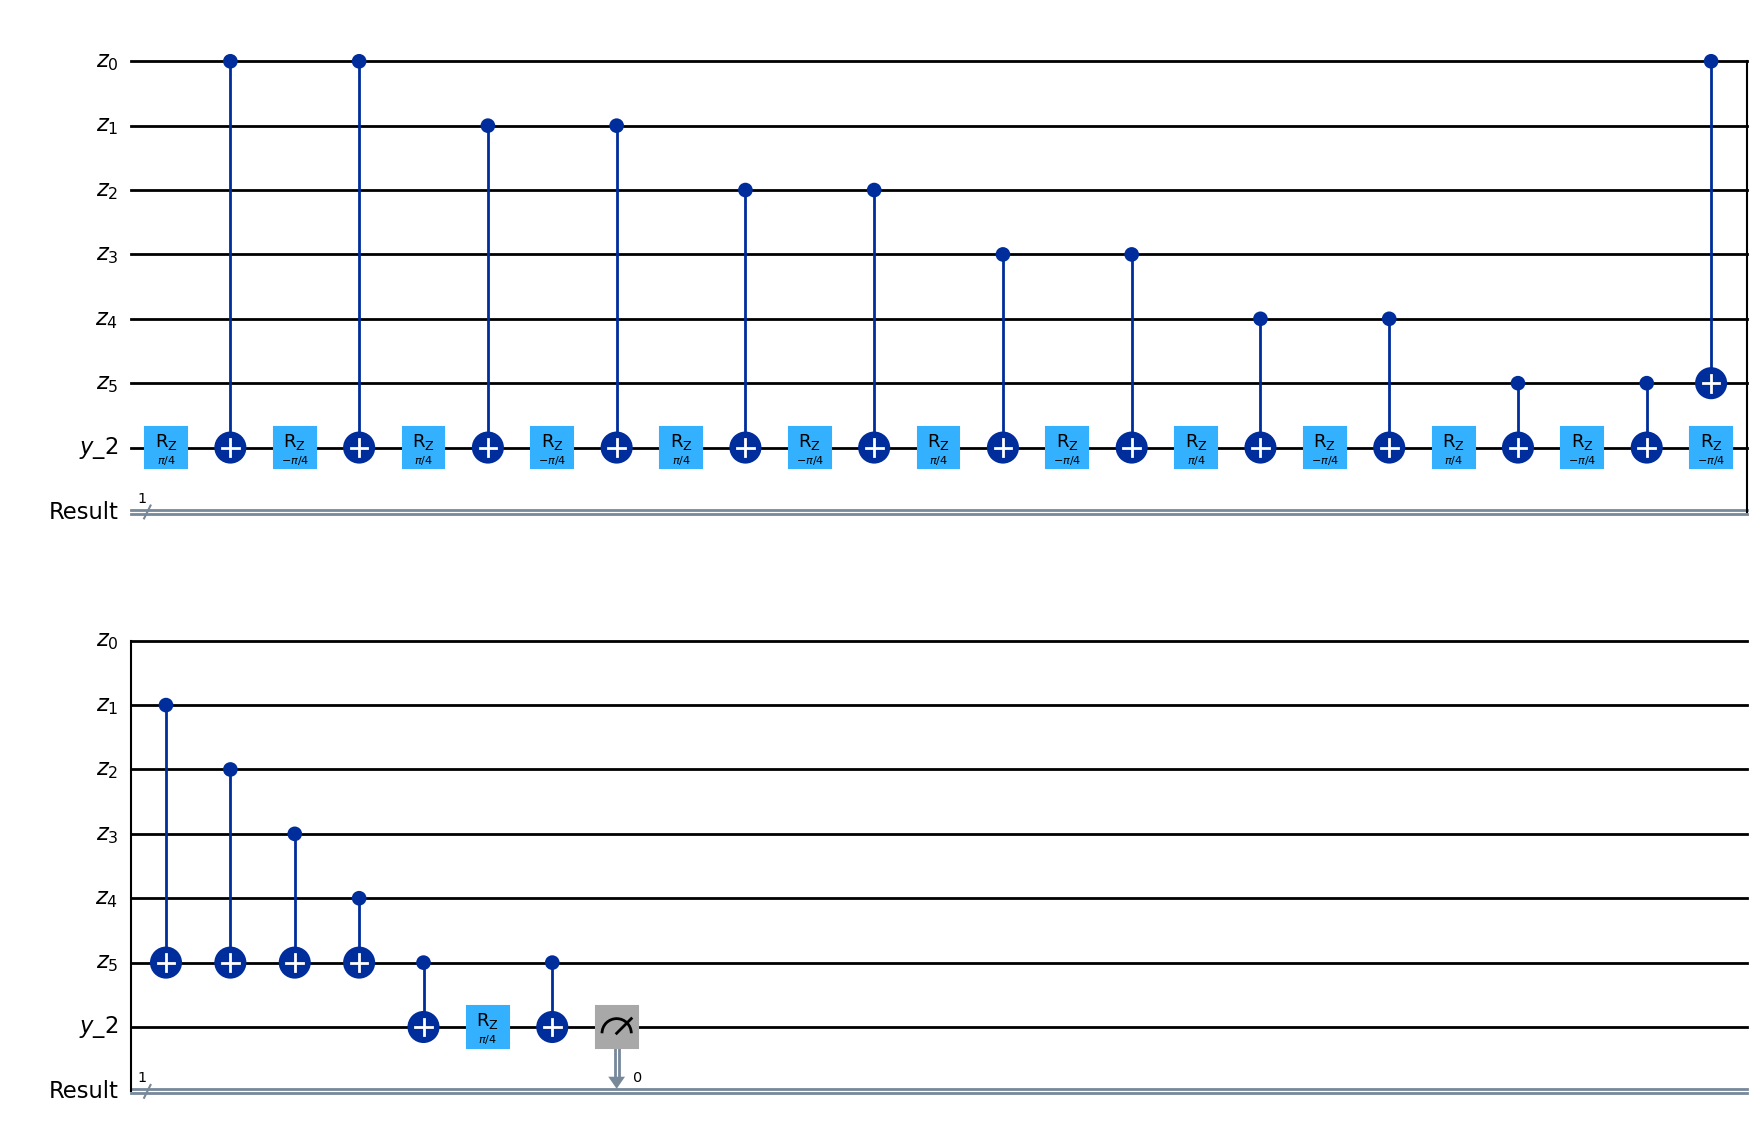

In [29]:
qreg = QuantumRegister(n, name="z")
qreg_result = QuantumRegister(1, name="y_2")
creg = ClassicalRegister(1, name="Result")
qc = QuantumCircuit(qreg, qreg_result, creg, name="QFT popcount solution with crz decomposition")

create_QPE_popcount_circuit_rcz(qreg, qreg_result, creg, qc, n)
qc.draw("mpl")

Next, all different $2^n$ input combinations are generated an stored as numpy array

In [31]:
# The following lines generates all 2**n input combinations
input_states = np.empty((2**n, n), dtype=bool)
for i in range(2**n):
    input_states[i, :] = np.array(list(bin(i)[2:].zfill(n)), dtype=int).astype(bool)


This cell verifies that there are no redundant inputs in the list

In [32]:
test_list = []
for input_state in input_states:
    test_list.append(int("".join(input_state.astype(int).astype(str)), 2))

cur_length = len(test_list)
actual_unique_lenght = len(set(test_list))
if not (cur_length == actual_unique_lenght):
    print("There is a mistake in the generator function")

Finaly the circuit is tested by running the simulation for every possible input combination. The results are stored in a pandas dataframe and saved to a csv file in the current working directory with filename "popcount_QPE_analysis_n{n}.csv" ({n} depends on n)

In [ ]:
results = {"Input_dec" : [], "Input_bin" : [], "Hamming_weight" : [], "Expected_output" : [], "Measured_result" : []}
for input_state in input_states:
    cur_input_decimal = int("".join(input_state.astype(int).astype(str)), 2)
    cur_hamming_weight = np.sum(input_state.astype(int))
    # Here the output bit is determined by checking if the hamming weight value has the second bit set to 1
    expected_output = int(bin(np.sum(input_state.astype(int)))[2:].zfill(n)[-2])
    # Instantiate the registers and circuit objects
    cur_qreg = QuantumRegister(n, name="z")
    cur_qreg_result = QuantumRegister(1, name="y")
    cur_creg = ClassicalRegister(1, name="result")
    cur_qc = QuantumCircuit(qreg, cur_qreg_result, cur_creg)
    # Prepare current input state
    prepare_input_state(input_state, cur_qreg, cur_qc)
    # Create circuit
    create_QPE_popcount_circuit_rcz(cur_qreg, cur_qreg_result, cur_creg, cur_qc, n)
    # Instantiate the primitive simulator and run experimenbt with 500 shots
    result = Sampler().run([cur_qc], shots=500).result()
    # Format experiment result such that it can be trasnsformed into a pandas dataframe
    results["Input_dec"].append(cur_input_decimal)
    results["Input_bin"].append("".join(input_state.astype(int).astype(str)))
    results["Hamming_weight"].append(cur_hamming_weight)
    results["Expected_output"].append(expected_output)
    # Log thge measured result. If the final state is stochastic, then 0.5 is logged to indicate the error
    measured_keys = result.quasi_dists[0].keys()
    if len(measured_keys) > 1:
        results["Measured_result"].append(1/2)
    else:
        results["Measured_result"].append(list(measured_keys)[0])

results_df = pd.DataFrame(results)
results_df.to_csv(f"popcount_QPE_analysis_n{n}.csv")
results_df

,Input_dec,Input_bin,Hamming_weight,Expected_output,Measured_result
0,0,000000,0,0,0
1,1,000001,1,0,0
2,2,000010,1,0,0
3,3,000011,2,1,0
4,4,000100,1,0,0
...,...,...,...,...,...
59,59,111011,5,0,0
60,60,111100,4,0,0
61,61,111101,5,0,0
62,62,111110,5,0,0


The outputs can now be verified by aggregating over the measured result and expected result by taking the mean over all cases where the hamming weight is equal. If the expected and measured results match, then the circuit is working.

In [12]:
results_df.groupby(["Hamming_weight"])[["Expected_output", "Measured_result"]].mean()

,Expected_output,Measured_result
Hamming_weight,,
0,0.0,0.0
1,0.0,0.0
2,1.0,1.0
3,1.0,1.0
4,0.0,0.0
5,0.0,0.0
6,1.0,1.0
